In [150]:
import math
import time

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
import networkx as nx
import torch
import torch.nn as nn
from net import gtnet
import numpy as np
from util import *
from generate_index_data import get_stock_data

file_path = './model/model-ind.pt'
model = torch.load(file_path)

In [2]:
device = 'cuda:0'
data = './data/indices.csv'
horizon = 3
normalize = 2
seq_in_len = 24*7
num_nodes = 11 
subgraph_size = 11 
batch_size = 8
num_split = 3

Data = DataLoaderS(data, 0.6, 0.2, device, horizon, seq_in_len, normalize)
model = model.to(device)

print('The receptive field size is', model.receptive_field)
nParams = sum([p.nelement() for p in model.parameters()])
print('Number of model parameters is', nParams, flush=True)

The receptive field size is 187
Number of model parameters is 337585


In [3]:
evaluateL2 = nn.MSELoss(reduction='sum').to(device)
evaluateL1 = nn.L1Loss(reduction='sum').to(device)

In [4]:
def evaluate(data, X, Y, model, evaluateL2, evaluateL1, batch_size):
    model.eval()
    total_loss = 0
    total_loss_l1 = 0
    n_samples = 0
    predict = None
    test = None

    for X, Y in data.get_batches(X, Y, batch_size, False):
        X = torch.unsqueeze(X,dim=1)
        X = X.transpose(2,3)
        with torch.no_grad():
            output = model(X)
        output = torch.squeeze(output)
        if len(output.shape)==1:
            output = output.unsqueeze(dim=0)
        if predict is None:
            predict = output
            test = Y
        else:
            predict = torch.cat((predict, output))
            test = torch.cat((test, Y))

        scale = data.scale.expand(output.size(0), data.m)
        total_loss += evaluateL2(output * scale, Y * scale).item()
        total_loss_l1 += evaluateL1(output * scale, Y * scale).item()
        n_samples += (output.size(0) * data.m)

    rse = math.sqrt(total_loss / n_samples) / data.rse
    rae = (total_loss_l1 / n_samples) / data.rae

    predict = predict.data.cpu().numpy()
    Ytest = test.data.cpu().numpy()
    sigma_p = (predict).std(axis=0)
    sigma_g = (Ytest).std(axis=0)
    mean_p = predict.mean(axis=0)
    mean_g = Ytest.mean(axis=0)
    index = (sigma_g != 0)
    correlation = ((predict - mean_p) * (Ytest - mean_g)).mean(axis=0) / (sigma_p * sigma_g)
    correlation = (correlation[index]).mean()
    return rse, rae, correlation

In [5]:
test_acc, test_rae, test_corr = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, batch_size)
print("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr), flush=True)

test rse 0.0267 | test rae 0.0246 | test corr 0.9756


In [147]:
A = torch.round(model.gc(model.idx), decimals=4).cpu().detach().numpy()
G = nx.from_numpy_array(A.T, create_using=nx.DiGraph)
mapping = {0: "Italy", 1: r"T\"{u}rkiye", 2: "France", 3: "UK", 4: "Germany", 5: "US", 6: "Canada", 7: "Indonesia", 8: "Mexico", 9: "Japan", 10: "Nigeria"}
H = nx.relabel_nodes(G, mapping)

In [148]:
H.nodes

NodeView(('Italy', 'T\\"{u}rkiye', 'France', 'UK', 'Germany', 'US', 'Canada', 'Indonesia', 'Mexico', 'Japan', 'Nigeria'))

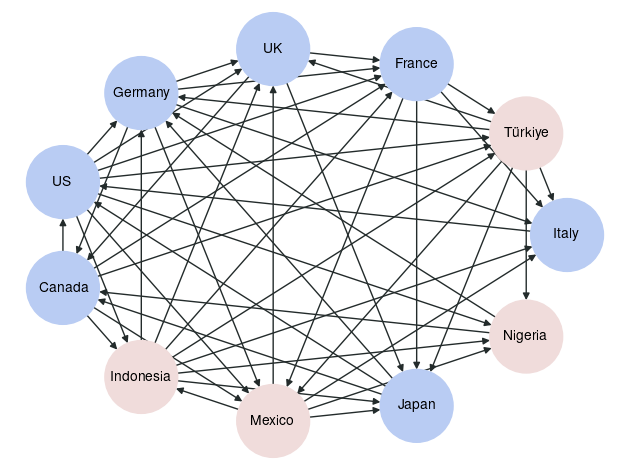

In [151]:
# https://www.color-hex.com/
fig = plt.figure()
ax=fig.add_subplot(111)

mint = '#f0dcdb'
g7 = '#b9ccf3'

nx.draw(H, with_labels=True, node_size=2750, font_size=10, font_color='black', font_weight='bold', font_family='sans-serif', node_color=[g7, mint, g7, g7, g7, g7, g7, mint, mint, g7, mint], edge_color='#232b2b', alpha=1.0, pos=nx.circular_layout(H), ax=ax)
fig.tight_layout()
fig.savefig("graph.eps", format='eps', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [13]:
np.round(A.T, decimals=1)

array([[0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 1. , 1. , 0. , 0. , 0. , 1. , 0.8, 1. ],
       [1. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 1. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 1. , 0. , 0. , 1. , 0. ],
       [1. , 0. , 1. , 1. , 0. , 0. , 0.9, 0. , 1. , 0. , 0. ],
       [0. , 1. , 1. , 1. , 1. , 0. , 0. , 1. , 1. , 0. , 1. ],
       [0. , 1. , 1. , 0. , 0. , 1. , 0. , 1. , 1. , 0. , 0. ],
       [1. , 1. , 1. , 1. , 1. , 0. , 0. , 0. , 0. , 1. , 1. ],
       [1. , 0. , 0. , 1. , 0. , 0. , 0. , 1. , 0. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 1. , 1. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 1. , 0. , 0. , 0. , 0. ]],
      dtype=float32)

## Time Series Forecasting

In [162]:
batch_size = 1
n_predict = None
n_test = None
predict = None
test = None

for X, Y in Data.get_batches(Data.test[0], Data.test[1], batch_size, False):
    X = torch.unsqueeze(X,dim=1)
    X = X.transpose(2,3)
    with torch.no_grad():
        output = model(X)
    output = torch.squeeze(output)
    if len(output.shape)==1:
        output = output.unsqueeze(dim=0)
    scale = Data.scale.expand(output.size(0), Data.m)
    if predict is None:
        predict = output * scale
        test = Y * scale
        n_predict = output
        n_test = Y
    else:
        predict = torch.cat((predict, output * scale))
        test = torch.cat((test, Y * scale))
        n_predict = torch.cat((n_predict, output))
        n_test = torch.cat((n_test, Y))
        

predict = predict.data.cpu().numpy()
Ytest = test.data.cpu().numpy()
n_predict = n_predict.data.cpu().numpy()
n_Ytest = n_test.data.cpu().numpy()

In [164]:
n_predict.shape, n_Ytest.shape

((917, 11), (917, 11))

In [171]:
Ybar = np.mean(Ytest, axis=0)
Ybar

array([10.212015 ,  8.57868  ,  8.858855 ,  8.935887 ,  9.642615 ,
        8.388082 ,  9.927565 ,  8.852349 , 10.869084 , 10.340662 ,
        7.7504673], dtype=float32)

In [185]:
# RAE, RSE computation
rae = []
rse = []
for i in range(11):
    rae += [np.sum(np.abs(predict[:,i] - Ytest[:,i])) / np.sum(np.abs(Ytest[:,1] - Ybar[i]))]
    rse += [np.sum((predict[:,i] - Ytest[:,i])**2) / np.sum((Ytest[:,1] - Ybar[i])**2)]
np.concatenate([rae, rse], axis=0).reshape(2, 11)

array([[1.2250494e-02, 7.5468577e-02, 3.5534408e-02, 3.2569259e-02,
        1.8506849e-02, 3.7279371e-02, 1.2639113e-02, 2.9065216e-02,
        8.0071874e-03, 1.1229030e-02, 2.1933936e-02],
       [1.9646068e-04, 6.3623297e-03, 1.1651764e-03, 8.5673167e-04,
        3.8664267e-04, 1.4621429e-03, 1.8648148e-04, 7.4028916e-04,
        9.0219997e-05, 1.7806339e-04, 6.8461261e-04]], dtype=float32)

In [90]:
original_data = get_stock_data(dt.datetime(2005, 1, 3), dt.datetime(2024, 8, 15))

[*********************100%%**********************]  10 of 10 completed
/home/icute/repos/research/graph-nn/mtgnn/generate_index_data.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  nse30['Open'].iloc[i] = locale.atof(nse30['Open'].iloc[

In [142]:
idx = pd.date_range(
    original_data.index[0].date(),
    original_data.index[-1].date(),
)
idx[int(len(idx)*0.8)::200]

DatetimeIndex(['2022-02-10', '2022-08-29', '2023-03-17', '2023-10-03',
               '2024-04-20'],
              dtype='datetime64[ns]', freq='200D')

In [112]:
from matplotlib import dates

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


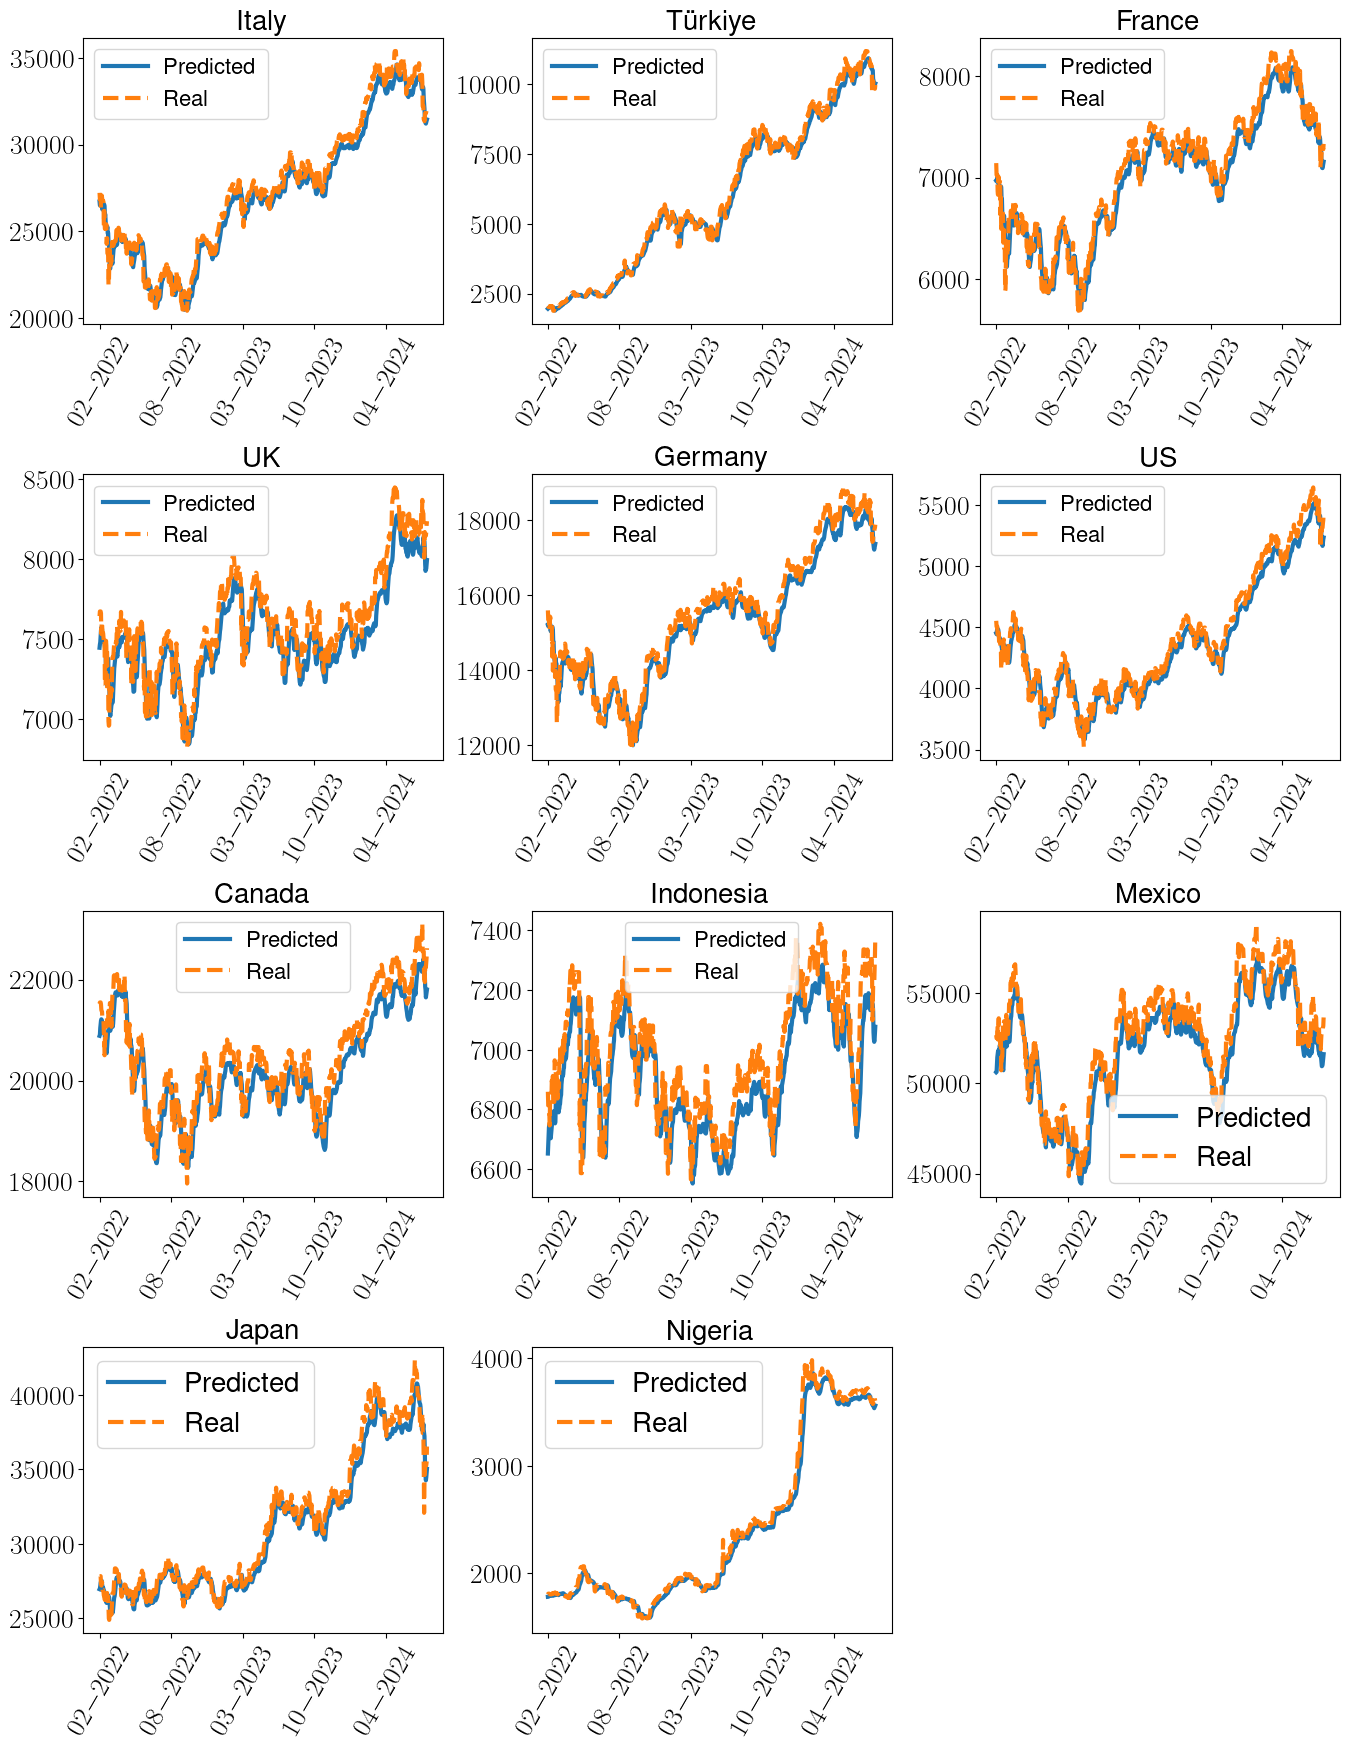

In [155]:
fig = plt.figure(figsize=(8.5*1.6, 11*1.6))
for i in range(8):
    ax = fig.add_subplot(4,3, 1+i)
    ax.plot(idx[int(len(idx)*0.8):], np.exp(predict[:,i]), label='Predicted', linewidth=3)
    ax.plot(idx[int(len(idx)*0.8):], np.exp(Ytest[:,i]), label='Real', linewidth=3, linestyle='dashed')
    ax.set_title(mapping[i], fontsize=20)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))
    plt.xticks(rotation=60)
    plt.legend(loc='best', fontsize=16)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.set_xticks(idx[int(len(idx)*0.8)::200])
#     ax.set_xticks([])
    
    
for i in range(8, 11):
    ax = fig.add_subplot(4,3, 1+i)
    ax.plot(idx[int(len(idx)*0.8):], np.exp(predict[:,i]), label='Predicted', linewidth=3)
    ax.plot(idx[int(len(idx)*0.8):], np.exp(Ytest[:,i]), label='Real', linewidth=3, linestyle='dashed')
    ax.set_title(mapping[i], fontsize=20)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))
    plt.xticks(rotation=60)
    plt.legend(loc='best', fontsize=20)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.set_xticks(idx[int(len(idx)*0.8)::200])

fig.tight_layout()
# ax = fig.add_subplot(431)
# ax.plot(idx[int(len(idx)*0.8):], np.exp(predict[:,5]), label='Predicted', linewidth=3)
# ax.plot(idx[int(len(idx)*0.8):], np.exp(Ytest[:,5]), label='Real', linewidth=3, linestyle='dashed')
# ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))
# plt.xticks(rotation=60)
# plt.legend(loc='best', fontsize=20)
# ax.xaxis.set_tick_params(labelsize=20)
# ax.yaxis.set_tick_params(labelsize=20)
fig.savefig("predictions.eps", format='eps', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [37]:
X

tensor([[[0.9711, 0.7819, 0.9773,  ..., 0.9888, 0.9600, 0.8922],
         [0.9706, 0.7819, 0.9768,  ..., 0.9891, 0.9604, 0.8923],
         [0.9704, 0.7812, 0.9761,  ..., 0.9892, 0.9605, 0.8922],
         ...,
         [0.9751, 0.8136, 0.9827,  ..., 0.9871, 0.9581, 0.9047],
         [0.9751, 0.8136, 0.9827,  ..., 0.9871, 0.9581, 0.9047],
         [0.9731, 0.8122, 0.9817,  ..., 0.9871, 0.9589, 0.9044]],

        [[0.9706, 0.7819, 0.9768,  ..., 0.9891, 0.9604, 0.8923],
         [0.9704, 0.7812, 0.9761,  ..., 0.9892, 0.9605, 0.8922],
         [0.9700, 0.7808, 0.9763,  ..., 0.9896, 0.9598, 0.8922],
         ...,
         [0.9751, 0.8136, 0.9827,  ..., 0.9871, 0.9581, 0.9047],
         [0.9731, 0.8122, 0.9817,  ..., 0.9871, 0.9589, 0.9044],
         [0.9718, 0.8152, 0.9820,  ..., 0.9875, 0.9589, 0.9042]],

        [[0.9704, 0.7812, 0.9761,  ..., 0.9892, 0.9605, 0.8922],
         [0.9700, 0.7808, 0.9763,  ..., 0.9896, 0.9598, 0.8922],
         [0.9700, 0.7808, 0.9763,  ..., 0.9896, 0.9598, 0.

In [38]:
Y

tensor([[0.9749, 0.8178, 0.9841, 0.9890, 0.9806, 0.9751, 0.9929, 0.9911, 0.9899,
         0.9606, 0.9044],
        [0.9736, 0.8165, 0.9823, 0.9894, 0.9790, 0.9739, 0.9931, 0.9904, 0.9896,
         0.9606, 0.9049],
        [0.9736, 0.8165, 0.9823, 0.9894, 0.9790, 0.9739, 0.9931, 0.9904, 0.9896,
         0.9606, 0.9049],
        [0.9736, 0.8165, 0.9823, 0.9894, 0.9790, 0.9739, 0.9931, 0.9904, 0.9896,
         0.9606, 0.9049]], device='cuda:0')

In [46]:
X.shape

torch.Size([4, 168, 11])

In [47]:
X = torch.unsqueeze(X,dim=1)

In [48]:
X.shape

torch.Size([4, 1, 168, 11])

In [22]:
X.transpose(2,3)

tensor([[[[0.9711, 0.9706, 0.9704,  ..., 0.9751, 0.9751, 0.9731],
          [0.7819, 0.7819, 0.7812,  ..., 0.8136, 0.8136, 0.8122],
          [0.9773, 0.9768, 0.9761,  ..., 0.9827, 0.9827, 0.9817],
          ...,
          [0.9888, 0.9891, 0.9892,  ..., 0.9871, 0.9871, 0.9871],
          [0.9600, 0.9604, 0.9605,  ..., 0.9581, 0.9581, 0.9589],
          [0.8922, 0.8923, 0.8922,  ..., 0.9047, 0.9047, 0.9044]]]],
       device='cuda:0')

In [27]:
output = model(X.transpose(2,3))
output = torch.squeeze(output)
output

tensor([0.9731, 0.8130, 0.9814, 0.9861, 0.9781, 0.9725, 0.9899, 0.9877, 0.9863,
        0.9576, 0.9029], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [28]:
predict = output
test = Y

In [30]:
predict = predict.data.cpu().numpy()
Ytest = test.data.cpu().numpy()
predict, Ytest

(array([0.9731336 , 0.81298226, 0.9813771 , 0.9860644 , 0.9780561 ,
        0.9725034 , 0.9899485 , 0.98771113, 0.9862684 , 0.9575547 ,
        0.9029038 ], dtype=float32),
 array([[0.9748976 , 0.81783503, 0.9841128 , 0.98895895, 0.98062605,
         0.97513765, 0.99293053, 0.9911495 , 0.98990583, 0.96056414,
         0.90442234]], dtype=float32))